In [1]:
import numpy as np

## 1.定义F1评价指标
该指标将在后面参与参数的选择<br/>
$$ F1=\frac{2*Precision*Recall}{Precision+Recall} $$

In [2]:
def F1(predictions, y):
    TP = np.sum((predictions == 1) & (y == 1))
    FP = np.sum((predictions == 1) & (y == 0))
    FN = np.sum((predictions == 0) & (y == 1))
    if TP + FP == 0:
        precision = 0
    else:
        precision = float(TP) / (TP + FP)
    if TP + FN == 0:
        recall = 0
    else:
        recall = float(TP) / (TP + FN)
    if precision + recall == 0:
        return 0
    else:
        return (2.0 * precision * recall) / (precision + recall)

##  2.定义普通高斯函数
高斯分布的密度函数：$$ p(x;\mu, \sigma^2) = \frac{1}{\sqrt{2\pi}\sigma}exp(-\frac{(x-\mu)^2}{2\sigma^2}) $$
函数模型 $ p(x) $ 为：$$ p(x) = p(x_1;\mu_1,\sigma_1^2) \times p(x_2;\mu_2,\sigma_2^2) \times  ... \times  p(x_n;\mu_n,\sigma_n^2) $$<br/>
其中 $ x_i,i=1,2,...,n $ 是样本的特征，需对每个样本求其高斯分布密度函数

In [63]:
def gaussianModel(X):
    # 参数估计
    m, n = X.shape
    mu = np.mean(X, axis=0) # 1*n维
    sigma2 = np.var(X, axis=0) # 1*n维,是sigma的平方
    
    def p(x):
        # x是单个样本，n*1维
        total = 1
        for j in range(x.shape[0]):
            total *= np.exp(-np.power((x[j,0] - mu[0,j]), 2) / (2 * sigma2[0,j])) / (np.sqrt(2*np.pi*sigma2[0,j]))
        return total
    return p

## 3. 定义多元高斯函数
多元高斯分布的密度函数： $$ p(x;\mu,\Sigma) = \frac{1}{(2\pi)^{\frac{n}{2}}{\mid \Sigma \mid}^{\frac{1}{2}}} exp (-\frac{1}{2}(x-\mu)^T \Sigma^{-1} (x-\mu)) $$ 

In [64]:
def multivariateGaussianModel(X):
    # 参数估计
    m, n = X.shape
    mu = np.mean(X.T, axis = 1) # n*1维
    Sigma = np.mat(np.cov(X.T)) # n*n维
    # 计算sigma的行列式
    detSigma = np.linalg.det(Sigma)
    
    def p(x): # x为单个样本，n*1维
        x = x - mu
        return np.exp(-x.T * np.linalg.pinv(Sigma) * x/2).A[0] / (np.power((2*np.pi),n/2)*np.power(Sigma,1/2))
    return p
        

## 4. 定义训练函数

In [65]:
def train(X, model=gaussianModel):
    return model(X)

## 5. 定义参数 $ \epsilon $ 选择函数

In [66]:
def selectEpsilon(XVal, yVal, p):
    # 利用交叉验证集，以及F1来选取合适的参数
    # 交叉验证集中所有样本的概率
    pVal = np.mat([p(x.T) for x in XVal]).reshape(-1,1)  # 维度为：交叉验证集样本数*1
    step = (np.max(pVal) - np.min(pVal)) / 1000.0
    
    bestEpsilon = 0
    bestF1 = 0
    
    for epsilon in np.arange(np.min(pVal), np.max(pVal), step):
        predictions = pVal < epsilon
        f1 = F1(predictions, yVal)
        if f1 > bestF1:
            bestF1 = f1
            bestEpsilon = epsilon
    return bestEpsilon, bestF1

In [67]:
%matplotlib inline

In [68]:
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [69]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

基于交叉验证集最佳ε: 8.990853e-05

基于交叉验证集最佳F1:  0.875000

找到 6 个异常点


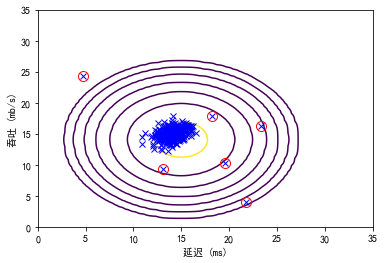

In [70]:
# 低维数据测试
data = loadmat('data/ex8data1.mat')
X = np.mat(data['X'])
XVal = np.mat(data['Xval'])
yVal = np.mat(data['yval'])

p = train(X)
#p = train(X, model=multivariateGaussianModel)
pTest = np.mat([p(x.T) for x in X]).reshape(-1, 1)

# 绘制数据点
plt.xlabel(u'延迟 (ms)')
plt.ylabel(u'吞吐 (mb/s)')
plt.plot(X[:, 0], X[:, 1], 'bx')
epsilon, f1 = selectEpsilon(XVal, yVal, p)

print('基于交叉验证集最佳ε: %e\n'%epsilon)
print('基于交叉验证集最佳F1:  %f\n'%f1)
print('找到 %d 个异常点' % np.sum(pTest < epsilon))

# 获得训练集的异常点
outliers = np.where(pTest < epsilon, True, False).ravel()
plt.plot(X[outliers, 0], X[outliers, 1], 'ro', lw=2, markersize=10, fillstyle='none', markeredgewidth=1)
n = np.linspace(0, 35, 100)
X1 = np.meshgrid(n,n)
XFit = np.mat(np.column_stack((X1[0].T.flatten(), X1[1].T.flatten())))
pFit = np.mat([p(x.T) for x in XFit]).reshape(-1, 1)
pFit = pFit.reshape(X1[0].shape)

if not np.isinf(np.sum(pFit)):
    plt.contour(X1[0], X1[1], pFit, 10.0**np.arange(-20, 0, 3).T)
plt.show()

In [72]:
# 高维数据
data = loadmat('data/ex8data2.mat')
X = np.mat(data['X'])
XVal = np.mat(data['Xval'])
yVal = np.mat(data['yval'])

p = train(X)
#p = train(X, model=multivariateGaussianModel)
pTest = np.mat([p(x.T) for x in X]).reshape(-1, 1)

epsilon, f1 = selectEpsilon(XVal, yVal, p)

print('Best epsilon found using cross-validation: %e\n'%epsilon)
print('Best F1 on Cross Validation Set:  %f\n'%f1)
print( '# Outliers found: %d' % np.sum(pTest < epsilon))

Best epsilon found using cross-validation: 1.377229e-18

Best F1 on Cross Validation Set:  0.615385

# Outliers found: 117
